In [6]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import os
import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst

# Visualization
from src.visualization import visualization as viz
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image 
import pydotplus

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Models
from src.modeling import modeling
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, plot_importance

# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error

# REMINDER - OBJECTIVE
Now we enter into the final but most exciting part: **build models that will be to be able to predict the price for a given listing**.  

In next sections below you will find all data transformation steps that are mandatory before giving it to models.  
This will be based on what we have discussed during the [Data Preparation](3_Data_Preparation.ipynb) phase.

# 1. Discuss about models and metrics to evaluate
## 1.1. Metrics
We have to predict a continuous variable, it is so a regression problem. It will not be a surprise: I am going to measure the performance of the model by using the **Root Mean Squared Error (RMSE)** metric. Why ? Because, as well said in this [analyticsvidhya blog post](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/):
> * The power of ‘square root’  empowers this metric to show large number deviations.
* The ‘squared’ nature of this metric helps to deliver more robust results which prevents cancelling the positive and negative error values. In other words, this metric aptly displays the plausible magnitude of error term.
* It avoids the use of absolute error values which is highly undesirable in mathematical calculations.
* When we have more samples, reconstructing the error distribution using RMSE is considered to be more reliable.
* RMSE is highly affected by outlier values. Hence, make sure you’ve removed outliers from your data set prior to using this metric.
* As compared to mean absolute error, RMSE gives higher weightage and punishes large errors.

## 1.1. Models
I will have few models to compare:
* a "naive" one that will predict the mean price of the neighbourhood the listing belongs to
* I will give a try to LinearRegression as our baseline model
* I would also like to give a try to _tree methods_ so I will go with the simple [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)
* In the end, I will try also XGBoost because I like it and it is quite simple to use.

As there will be different models wich will require different preparation steps **I will build different pipelines**.

### Naive model: apply neighbourhood mean price
Motivation: compare models with something very simple that does not even require machine learning and see how much we do better (or not...).  
I could have applied the mean price of the whole dataset, that would have been even more naive but let's challenge it a little bit as we have seen that price varies from one neighbourhood to another. In the chosen use case, as a customer, I would expect a listing to cost something around the mean in the neighbourhood. Of course there are much more features that have impacts on the mean (I guess that number of beds, accomodates and so on are part of that but let's keep things simple, it's a naive predictor after all...).  
**There is no particular thing to do for this predictor.**

### Linear Regression
Motivation: this is a very basic model but which sometimes give good results and could be an outsider due to the computation time which is not very high.  
**Features have to be scaled** (I will use StandardScaler so that it will be centered around 0 and have variance in the same order).  
**No missing value allowed**: imputation as decided in previous [notebook](3_Data_Preparation.ipynb).

### Decision Tree
Motivation: The cool thing with trees is that it will then be possible to have a look at features importance and see what are the ones that contribute the most to the prediction value. We can also plot the tree by using package such as `graphviz`.  
One of the advantages is that it **does not require feature scaling** so no big effort to run it.  
But they have also **counterparts** as we can read here in [sklearn API documentation](https://scikit-learn.org/stable/modules/tree.html#tree): **"overfitting, unstability or biased trees if some classes dominate"**.
**No missing value allowed**: imputation as decided in previous [notebook](3_Data_Preparation.ipynb).

### Extreme Gradient Boosting (XGBoost)
Motivation: I would like to try an ensemble method. I have already used it and XGBoost has proven to be a very powerful machine learning technique which is often used on Kaggle competitions.

#### What is an ensemble method ?
There is a [very good article here](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205) describing that. Main thing to retain is that: _"Ensemble learning is a machine learning paradigm where multiple models (often called “weak learners”) are trained to solve the same problem and combined to get better results. The main hypothesis is that when weak models are correctly combined we can obtain more accurate and/or robust models."_  
The main principle is: instead of building a very complex model that tries to understand and fits very well the data or even finds relationships between columns of the data table (that would obviously lead us to something really complex and hard to understand), it builds a lot of simple decision trees.  
Each tree, taken independently is very simple (let's say basic or even naive) but the strength here is that combining predictions coming from all those basic estimators will provide in the end a stronger model, so a better prediction.

#### Several technics and main differences
There are several ensemble technics: bagging, boosting, stacking. For [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) which is explained in details [here](https://xgboost.readthedocs.io/en/latest/tutorials/model.html), we are in _'boosting'_ case.
While _'bagging'_ is faster because training is made in parallel independently and result is an average value of all learners, _'boosting'_ is a little bit longer due to the fact that training is sequential: over iterations, a new learner (tree) is added.  
Those new trees are built in such a way that each time we add it to the list of already built ones, they will focus on reducing the errors made by the combination of all the others, making then the 'ensemble' more powerful. Due to this sequence, it may take time to train such a model but it remains affordable compared to other algorithms and tests results give pretty good and encouraging metrics so it is a good compromise.

#### Pipeline steps
* XGBoost **does not require feature scaling** ([1](https://github.com/dmlc/xgboost/issues/357) and[2](https://www.quora.com/Why-is-it-not-a-good-idea-to-do-feature-scaling-for-xgboost))
* **No missing value allowed** so imputation as well

As our problem is a regression one, I will use [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor). As discussed earlier, to ***check the performance of our model*** and as written in this [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters), **RMSE** should be chosen as eval_metric when problem is a regression one.

XGBoost model will be trained on train dataset, tuned by using the validation dataset, and used on test dataset. For tuning parameters, here is a good reading: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [2]:
X_train = pd.read_csv(datacollector.get_data_file(cst.LST_X_TRAIN_FILE, True), sep=',', header=0)
y_train = pd.read_csv(datacollector.get_data_file(cst.LST_Y_TRAIN_FILE, True), sep=',', header=None)
X_val = pd.read_csv(datacollector.get_data_file(cst.LST_X_VAL_FILE, True), sep=',', header=0)
y_val = pd.read_csv(datacollector.get_data_file(cst.LST_Y_VAL_FILE, True), sep=',', header=None)
X_test = pd.read_csv(datacollector.get_data_file(cst.LST_X_TEST_FILE, True), sep=',', header=0)
y_test = pd.read_csv(datacollector.get_data_file(cst.LST_Y_TEST_FILE, True), sep=',', header=None)

y_train.columns = ['train_price']
y_val.columns = ['val_price']
y_test.columns = ['test_price']

In [67]:
print("X_train.shape is {}".format(X_train.shape))
print("y_train.shape is {}".format(y_train.shape))
print("X_val.shape is {}".format(X_val.shape))
print("y_val.shape is {}".format(y_val.shape))
print("X_test.shape is {}".format(X_test.shape))
print("y_test.shape is {}".format(y_test.shape))

X_train.shape is (52076, 153)
y_train.shape is (52076, 1)
X_val.shape is (5787, 153)
y_val.shape is (5787, 1)
X_test.shape is (6430, 153)
y_test.shape is (6430, 1)


---
# 2. Transformation pipeline
We can use [sklearn ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) to build a pipeline that will act differently depending on columns. And this is exactly what we want !

In [6]:
ct_imput = modeling.get_column_transformer()

---
# 3. Models
## 3.1. Naive model evaluation
The strategy, if were authorized to call it strategy, is to give the mean price value for the neighbourhood the listings belongs to. So we will 'learn' from `X_train dataset` what is the mean price per neighbourhood and then apply that to `X_test`. And that's all.

In [68]:
# Let's build back X_train + y_train
train_dataset = pd.concat([X_train, y_train], axis=1)

# Note that neighbourhood has been converted to dummies so let's take all column names related to this original feature
neigh_cols = [x for x in X_train.columns.tolist() if x.startswith('neighbourhood')]
# And then for each compute the mean price value
mean_price = {}
for col in neigh_cols:
    mean_price[col] = train_dataset[train_dataset[col] == 1]['train_price'].mean()
mean_price

{'neighbourhood_cleansed_Batignolles-Monceau': 107.0256121587391,
 'neighbourhood_cleansed_Bourse': 144.3280977312391,
 'neighbourhood_cleansed_Buttes-Chaumont': 81.39932318104907,
 'neighbourhood_cleansed_Buttes-Montmartre': 86.72472862957937,
 'neighbourhood_cleansed_Entrepôt': 101.16574125485842,
 'neighbourhood_cleansed_Gobelins': 82.10800842992624,
 'neighbourhood_cleansed_Hôtel-de-Ville': 155.04851921865153,
 'neighbourhood_cleansed_Louvre': 178.36761904761906,
 'neighbourhood_cleansed_Luxembourg': 177.747591522158,
 'neighbourhood_cleansed_Ménilmontant': 74.52281746031746,
 'neighbourhood_cleansed_Observatoire': 101.84720121028744,
 'neighbourhood_cleansed_Opéra': 135.3331934536299,
 'neighbourhood_cleansed_Palais-Bourbon': 181.72751859364436,
 'neighbourhood_cleansed_Panthéon': 128.46184738955824,
 'neighbourhood_cleansed_Passy': 167.47653567340708,
 'neighbourhood_cleansed_Popincourt': 91.53527457494626,
 'neighbourhood_cleansed_Reuilly': 87.88053505535055,
 'neighbourhood_cle

In [69]:
# Now we build our 'prediction array' and for each row of the X_test dataset, we take the mean price value corresponding to the
# neighbourhood this listing belongs to
naive_y_pred = []
for index, row in X_test.iterrows():
    test_neigh_row = [col for col in neigh_cols if row[col] == 1]
    naive_y_pred.append(mean_price[test_neigh_row[0]])

In [70]:
# Model evaluation metric
print("RMSE for naive predictor: {:.2f}".format(np.sqrt(mean_squared_error(y_test, naive_y_pred))))

RMSE for naive predictor: 138.02


## 3.2. LinearRegression model run & evaluation

In [71]:
# For linear regression, we will perform imputation + feature scaling
reglinear_pipeline = Pipeline(steps=[
    ('imputation', ct_imput),
    ('scaler', StandardScaler()),
    ('estimator', LinearRegression())])

In [72]:
reglinear_y_pred_test = modeling.fit_and_run_pipeline(reglinear_pipeline, "linear regression", X_train, y_train, X_test, y_test)

RMSE for linear regression model on train: 141.72
RMSE for linear regression model on test: 113.43


## 3.3. DecisionTreee model run & evaluation
### 3.3.1. Build basic DecisionTree

In [74]:
# For decision tree, we will only perform imputation
# Try to reduce memory consumption, the complexity and size of the trees with arbitrary values for max_depth and min_samples_split
dt_pipeline = Pipeline(steps=[
    ('imputation', ct_imput), 
    ('estimator', DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_split=10))])

In [75]:
dt_y_pred_test = modeling.fit_and_run_pipeline(dt_pipeline, "decision tree", X_train, y_train, X_test, y_test)

RMSE for decision tree model on train: 104.85
RMSE for decision tree model on test: 186.95


### 3.3.2. Feature importances
I used this [great resource from Chris Albon](https://chrisalbon.com/machine_learning/trees_and_forests/feature_importance/) to do that.

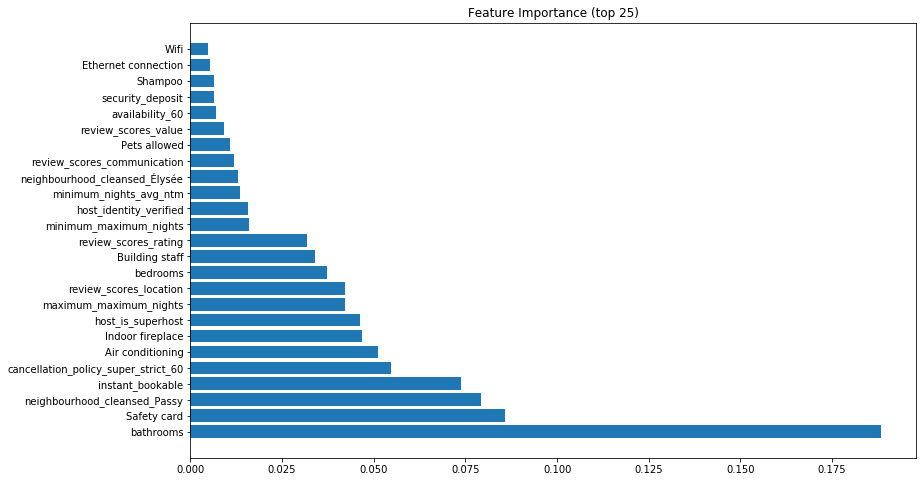

In [12]:
viz.plot_feature_importances(dt_pipeline['estimator'].feature_importances_, X_test.columns.tolist())

**Observations:**
* `bathrooms` feature is near 20% of importance ! 2nd one is `Safety card`, probably meaning that price increases when there is one.
* we have also some amenities in the TOP 25 such as `Air conditioning`, `fireplace`, the number of `bedrooms`.
* Neighbourhoods `Passy` and `Elysée` are the most important ones, the others do not even appear in this TOP 25.
* The overall `reviews_scores_rating` is here
* There are strange elements such as `Wifi` because if I well remember, almost all listings had Wifi.

### 3.3.3. DecisionTree visualization
Here I will use `graphviz` package so that the tree can be observed (and then, explained). Thanks to Russel for his [blog post](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176).

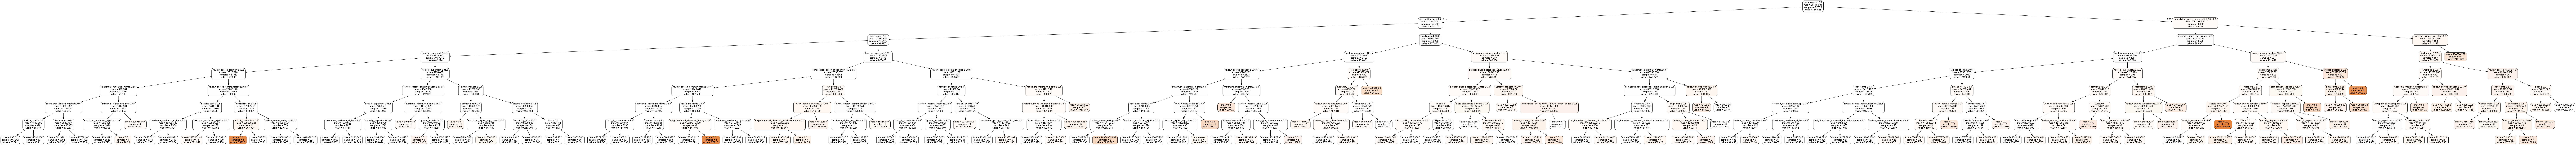

In [19]:
# Trick found here to avoid error: https://datascience.stackexchange.com/questions/37428/graphviz-and-pydotplus-not-working
os.environ['PATH'] = os.environ['PATH'] + ';' + os.environ['CONDA_PREFIX'] + r"\Library\bin\graphviz"

dot_data = StringIO()
export_graphviz(dt_pipeline['estimator'], feature_names=X_test.columns.tolist(), out_file=dot_data, filled=True, 
                rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This is not very easy to read so here is a sample of the tree:  
<img src="../assets/decision_tree_sample.png" width="750" />  
As you can see we have respected the given constaint of max_depth as there are only 8 levels in the tree.  
The name of the feature that is inspected for splitting is written in the cell with the criteria (here for instance we have a choice on _"cancellation_policy_super_strict_60"_ with a treshold value of 0.5. If True then we go on the left, if False we go on the right. And so on until we have satisfied conditions for our tree (i.e we have reached the max_depth or the min_samples_split value for leaves).

### 3.3.4. DecisionTree Tuning with GridSearch
**RMSE without tuning** and just random values gave this result **on test dataset: 186.95**. Our baseline model **(LinearRegression) gave 113.43**. Can we do better with DecisionTree and decrease this RMSE value ?  
This is what I will try next by exploring some estimator parameters value within a **GridSearch Cross Validation**.

In [51]:
# K-fold cross validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Parameters of the tree that may change
param_grid = {
    # The maximum depth of the tree
    'max_depth': [5, 8, 10, 12],
    # The minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 5, 10],
    # The minimum number of samples required to split an internal node
    'min_samples_split': [5, 10, 20]
}

dt_pipeline_optimization = Pipeline(steps=[
    ('imputation', ct_imput), 
    ('estimator', GridSearchCV(
        estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, n_jobs=-1, cv=kf, 
        scoring='neg_mean_squared_error', refit=True, verbose=1)
    )])

In [52]:
dt_tuned_y_pred_test = modeling.fit_and_run_pipeline(dt_pipeline_optimization, "optimized decision tree", X_train, y_train, X_test, y_test)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.8min finished


RMSE for optimized decision tree model on train: 125.43
RMSE for optimized decision tree model on test: 114.46


**114.46** is better than 186 and closer to the LinearRegression result but it is still higher. Let's see what is the best estimator that has been found:

In [56]:
dt_pipeline_optimization['estimator'].best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [57]:
# Mean cross-validated score of the best_estimator
dt_pipeline_optimization['estimator'].best_score_

-19903.56172706098

## 3.4. XGBoost at the rescue ?
My first idea was to **use X_val as evaluation dataset for early stopping** but when I launched it in the pipeline it raised an error. After reading this [article](https://stackoverflow.com/questions/50824326/xgboost-with-gridsearchcv-scaling-pca-and-early-stopping-in-sklearn-pipeline) I understand the issue which is _"fit method requires an evaluation set created externally, but we cannot create one before the transformation by the pipeline."_.  
A workaround is provided is proposed but with comments saying that it might not work. For the moment I will keep classic pipeline, I just removed some data for nothing and I could have used them for training.

In [78]:
# K-fold cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameters of xgboost that may change
param_grid = {
    'n_estimators': [100, 200, 300], # Number of estimators (weak learners)
    'learning_rate': [0.01, 0.1], # Learning rate
    'colsample_bytree': [0.5, 0.6], # subsample ratio of columns when constructing each tree (range is [0, 1])
    'max_depth': [5, 6, 7]  # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
}

xgb_pipeline_optimization = Pipeline(steps=[
    ('imputation', ct_imput), 
    ('estimator', GridSearchCV(
        estimator=XGBRegressor(objective="reg:squarederror", seed=42), param_grid=param_grid,
        n_jobs=-1, cv=kf, scoring='neg_mean_squared_error', refit=True, verbose=1)
    )])

In [79]:
xgb_y_pred_test = modeling.fit_and_run_pipeline(xgb_pipeline_optimization, "optimized XGBoost", X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 60.0min finished


RMSE for optimized XGBoost model on train: 40.59
RMSE for optimized XGBoost model on test: 102.73


In [80]:
xgb_pipeline_optimization['estimator'].best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=1, verbosity=1)

**Observations:**
* With a **RMSE of 102.73 this is so far our best model**
* RMSE=40 for train and 102 for test, one could say it overfits ! That's why early stopping could help us.
* We are absolutely not sure that we have found the best pararameters with the grid search, it is only the best combination among the search space we gave. We could try to extend it with a [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and explore values for `reg_alpha` parameter which is a regularization one for example.

### Interpreting the RMSE value
102.73 is still a lot, much more that what I have thought. It means that 102€ is the square root of the average of squared errors between the truth and our prediction. As the mean price for listing is 116€ or something like that, I think this is still a lot.

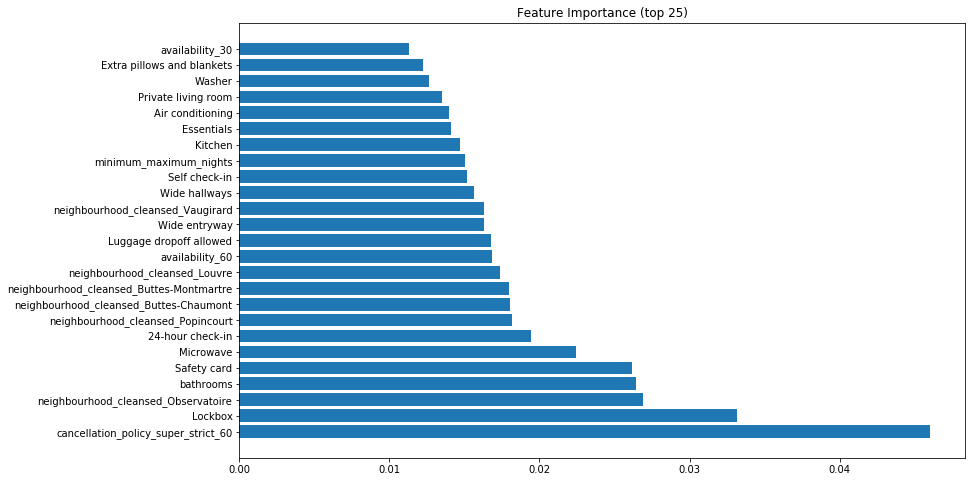

In [86]:
viz.plot_feature_importances(xgb_pipeline_optimization['estimator'].best_estimator_.feature_importances_, X_test.columns.tolist())

**Observations**:
* We find again the `cancellation_policy_super_strict_60` that the basic DecisionTree found as well.
* There are more `neighbourhoods` in this TOP 25 (Louvre, Montmartre, Observatoire, ...)
* `Safety card` and `bathrooms` are still here (respectively 4th and 5th)
* The distribution is not the same as for the DecisionTree: indeed here with xgbost the most important feature counts for near 5% (it was 18% with DecisionTree).

---
# 4. Results comparison table & error analysis
To have a better intuition on how 'accurate' our models were, I will concatenate all predictions for our models and compare that to the ground truth. This results file will be saved so that it can be loaded later for further investigations.

In [102]:
results_df = pd.concat([y_test, 
                        pd.DataFrame(data=naive_y_pred), 
                        pd.DataFrame(data=reglinear_y_pred_test),
                        pd.DataFrame(data=dt_y_pred_test),
                        pd.DataFrame(data=dt_tuned_y_pred_test),
                        pd.DataFrame(data=xgb_y_pred_test)
                       ], axis=1)
results_df.columns = ['y_true', 'y_naive', 'y_linear_reg', 'y_dt', 'y_dt_tuned', 'y_xgboost']
datacollector.save_price_predictions_results(results_df)
results_df.head(20)

,y_true,y_naive,y_linear_reg,y_dt,y_dt_tuned,y_xgboost
0,59.0,74.522817,45.195558,81.153083,81.153083,70.189217
1,90.0,135.333193,77.015889,76.752695,76.752695,78.916878
2,46.0,101.165741,46.398082,60.234906,60.234906,46.676373
3,67.0,86.724729,89.676208,108.414222,108.414222,82.750992
4,59.0,86.724729,109.937520,81.153083,81.153083,82.958214
5,95.0,101.165741,115.052866,107.973891,107.973891,102.963348
6,90.0,87.880535,60.786273,81.153083,81.153083,71.842583
7,119.0,82.108008,393.991158,459.361702,459.361702,540.490051
8,90.0,91.535275,124.845861,133.932836,133.932836,123.691254
9,65.0,135.333193,53.491641,81.153083,81.153083,74.901314


**First observations:**
* On the 15 displayed rows, **most of the time the XGBoost prediction is not very far from the truth** so it seems it works pretty well
* **BUT**, and I am afraid that the high RMSE comes from there, sometimes it is totally wrong. For example the 540€ prediction while the truth was 119€. It is interesting to note that DecisionTree and LinearRegression was wrong as well with also big difference (XGBoost is the worst). Whereas for this listing our naive predictor was below. There is maybe something strange with this listing that deserves to be analyzed more deeply and perhaps it will help us to understand if there is something wrong in input data.

To go further let's try to classify our predictions into groups:
* very accurate (prediction is 2% less or more than the truth)
* pretty good: 2 to 5%
* good: 5 to 10%
* acceptable: 10 to 20%
* bad: 20 to 40%
* awful: more than 40%

The motivation is that it is not the same when you are wrong of 40€ if the actual price is 100€ or 1000€.

In [7]:
results_df = modeling.classify_results(results_df, 'y_naive')
results_df = modeling.classify_results(results_df, 'y_linear_reg')
results_df = modeling.classify_results(results_df, 'y_dt')
results_df = modeling.classify_results(results_df, 'y_dt_tuned')
results_df = modeling.classify_results(results_df, 'y_xgboost')

In [27]:
results_df.head(10)

,y_true,y_naive,y_linear_reg,y_dt,y_dt_tuned,y_xgboost,y_naive_perc_diff,y_naive_perc_diff_class,y_linear_reg_perc_diff,y_linear_reg_perc_diff_class,y_dt_perc_diff,y_dt_perc_diff_class,y_dt_tuned_perc_diff,y_dt_tuned_perc_diff_class,y_xgboost_perc_diff,y_xgboost_perc_diff_class
0,59.0,74.522817,45.195558,81.153083,81.153083,70.189220,26.31,5-bad (20% < x < 40%),23.40,5-bad (20% < x < 40%),37.55,5-bad (20% < x < 40%),37.55,5-bad (20% < x < 40%),18.96,4-acceptable (10% < x < 20%)
1,90.0,135.333193,77.015889,76.752695,76.752695,78.916880,50.37,6-awful (> 40%),14.43,4-acceptable (10% < x < 20%),14.72,4-acceptable (10% < x < 20%),14.72,4-acceptable (10% < x < 20%),12.31,4-acceptable (10% < x < 20%)
2,46.0,101.165741,46.398082,60.234906,60.234906,46.676373,119.93,6-awful (> 40%),0.87,1-very accurate (< 2%),30.95,5-bad (20% < x < 40%),30.95,5-bad (20% < x < 40%),1.47,1-very accurate (< 2%)
3,67.0,86.724729,89.676208,108.414222,108.414222,82.750990,29.44,5-bad (20% < x < 40%),33.85,5-bad (20% < x < 40%),61.81,6-awful (> 40%),61.81,6-awful (> 40%),23.51,5-bad (20% < x < 40%)
4,59.0,86.724729,109.937520,81.153083,81.153083,82.958210,46.99,6-awful (> 40%),86.33,6-awful (> 40%),37.55,5-bad (20% < x < 40%),37.55,5-bad (20% < x < 40%),40.61,6-awful (> 40%)
5,95.0,101.165741,115.052866,107.973891,107.973891,102.963350,6.49,3-good (5% < x < 10%),21.11,5-bad (20% < x < 40%),13.66,4-acceptable (10% < x < 20%),13.66,4-acceptable (10% < x < 20%),8.38,3-good (5% < x < 10%)
6,90.0,87.880535,60.786273,81.153083,81.153083,71.842580,2.35,2-pretty good (2% < x < 5%),32.46,5-bad (20% < x < 40%),9.83,3-good (5% < x < 10%),9.83,3-good (5% < x < 10%),20.17,5-bad (20% < x < 40%)
7,119.0,82.108008,393.991158,459.361702,459.361702,540.490050,31.00,5-bad (20% < x < 40%),231.09,6-awful (> 40%),286.02,6-awful (> 40%),286.02,6-awful (> 40%),354.19,6-awful (> 40%)
8,90.0,91.535275,124.845861,133.932836,133.932836,123.691250,1.71,1-very accurate (< 2%),38.72,5-bad (20% < x < 40%),48.81,6-awful (> 40%),48.81,6-awful (> 40%),37.43,5-bad (20% < x < 40%)
9,65.0,135.333193,53.491641,81.153083,81.153083,74.901310,108.20,6-awful (> 40%),17.71,4-acceptable (10% < x < 20%),24.85,5-bad (20% < x < 40%),24.85,5-bad (20% < x < 40%),15.23,4-acceptable (10% < x < 20%)


### RMSE and classification table results
| Model              | RMSE value on train | RMSE value on test | Nb class 1-very accurate (< 2%) | Nb class 2-pretty good (2% < x < 5%) | Nb class 3-good (5% < x < 10%) | Nb class 4-acceptable (10% < x < 20%) | Nb class 5-bad (20% < x < 40%) | Nb class 6-awful (> 40%) |
|--------------------|---------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
| Naive              | N/A                 | 138.02             | 148             | 240             | 453             | 727             | 1280             | 3582             |
| Linear Regression  | 141.72              | 113.43             | 219             | 326             | 526             | 1086             | 1696             | 2577             |
| Basic DecisionTree | 104.85              | 186.95             | 273             | 417             | 637             | 1161             | 1788             | 2154             |
| Tuned DecisionTree | 125.43              | 114.46             | 301             | 393             | 632             | 1120             | 1847             | 2137             |
| XGBoost            | 40.59               | 102.73             | 347             | 515             | 864             | 1409             | 1816             | 1479             |

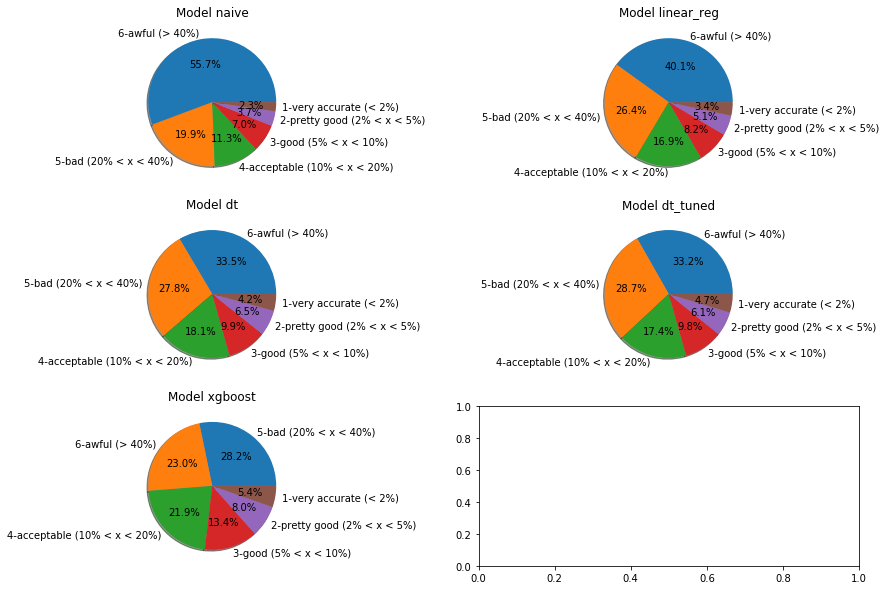

In [31]:
model_names = ['naive', 'linear_reg', 'dt', 'dt_tuned', 'xgboost']
viz.plot_classification_results_pie(model_names, results_df)

***Observations:***
* **XGBoost is our best candidate** for further tuning. We can see how it reduced the number of elements in class 6 (worst ones).
* Classes 1 to 4 ("very accurate (< 2%)", "pretty good (2% < x < 5%)", "good (5% < x < 10%)" and "acceptable (10% < x < 20%)") counts for 48.75% of the dataset in xgboost. It means than once in two our best model is at least 20% of the real value of the price. We definitely need to understand why and try to do better than that.
* **But the first try is overfitting** (see RMSE difference between train and test !)

Let's analyze how other models perform when xgboost is bad:

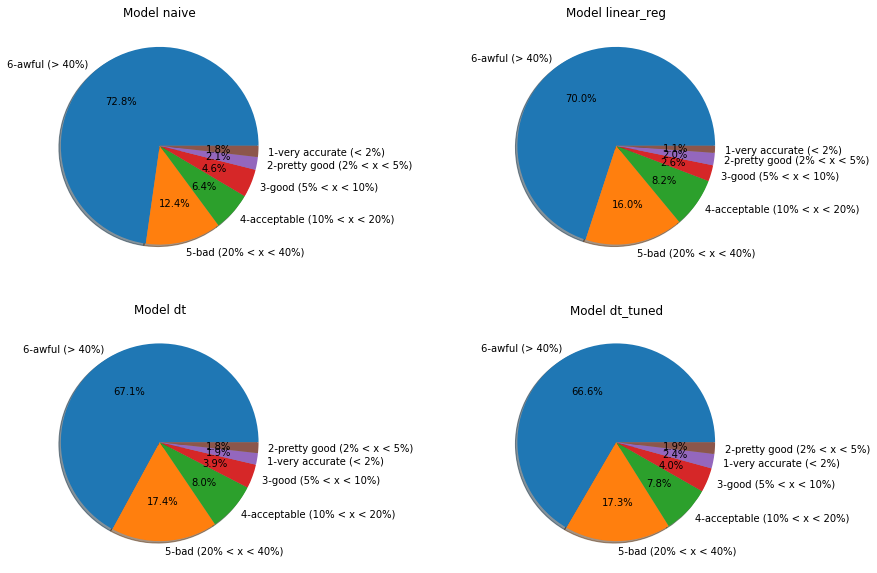

In [30]:
res_xgboost_awful = results_df[results_df['y_xgboost_perc_diff_class'] == '6-awful (> 40%)']
model_names_filter = ['naive', 'linear_reg', 'dt', 'dt_tuned']
viz.plot_classification_results_pie(model_names_filter, res_xgboost_awful)

***Observation:*** with our second best model (the tuned DecisionTree), when xgboost has poor results, 33% of the time this second model gives better result. Perhaps we could try to stack models ?

Our next goal will be to try to reduce overfitting. For that we will:
* Give a try to [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and explore values for `reg_alpha` parameter which is a regularization one for example.
* Try to use early stopping also

This will be done [here](4b_Modeling_Tuning_xgboost.ipynb).